# <center> Topic 3. Statistical Learning with Scikit-Learn

Сегодня вам предстоит на практике познакомиться с основными задачами машинного обучения.
В ходе работы получится поработать с популярными библиотеками [`pandas`](https://pandas.pydata.org/), [`numpy`](https://numpy.org/), [`sklearn`](https://scikit-learn.org/stable/).

Для выполнения задания необходимо следовать по этой тетрадке сверху вниз и заполнять недостающее части кода или отвечать на заданные вопросы.

In [33]:
# Импортируем необходимые библиотеки
# Полезно все импорты держать рядом

from os.path import exists

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering

%matplotlib inline

In [35]:
# Зафиксируем сид для генератора случайных чисел
# Это полезно для воспроизводимости результатов

RANDOM_SEED = 0xC0FFEE

# Классификация

Для знакомства с задачей классификацией воспользуемся выборкой данных о пациентах с доброкачественными и злокачественными опухолями. Наша задача — научиться их отличать.

Вместе с тетрадкой находится файл `cancer.csv` — это таблица, где каждая строчка соответствует отдельной клетке, а столбцы ее численные характеристики. Подробнее про датасет можно прочитать, например, вот [тут](
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data).

Начнем с чтения данных с диска, для этого реализуйте функцию `read_cancer_dataset`.
Поможет с этим библиотека `pandas` и пара полезных вещей из нее:
1. [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
2. [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [38]:
def read_cancer_dataset(path_to_csv: str, shuffle: bool = True) -> pd.DataFrame:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу cancer.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    # Your code here
    # Чтение данных из CSV-файла
    dataframe = pd.read_csv(path_to_csv)
    
    # Если нужно перемешать данные
    if shuffle:
        dataframe = dataframe.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    return dataframe

In [40]:
# Посмотрим на наши данные:
# Колонка "label" отвечает за тип опухоли
# Колонки 1-30 отвечают за признаки

cancer_dataset = read_cancer_dataset("cancer.csv", shuffle=True)
cancer_dataset.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,15.66,23.20,110.20,773.5,0.11090,0.31140,0.31760,0.13770,0.2495,...,19.85,31.64,143.70,1226.0,0.1504,0.5172,0.6181,0.24620,0.3277,0.10190
1,M,20.16,19.66,131.10,1274.0,0.08020,0.08564,0.11550,0.07726,0.1928,...,23.06,23.03,150.20,1657.0,0.1054,0.1537,0.2606,0.14250,0.3055,0.05933
2,B,11.30,18.19,73.93,389.4,0.09592,0.13250,0.15480,0.02854,0.2054,...,12.58,27.96,87.16,472.9,0.1347,0.4848,0.7436,0.12180,0.3308,0.12970
3,B,10.96,17.62,70.79,365.6,0.09687,0.09752,0.05263,0.02788,0.1619,...,11.62,26.51,76.43,407.5,0.1428,0.2510,0.2123,0.09861,0.2289,0.08278
4,M,23.09,19.83,152.10,1682.0,0.09342,0.12750,0.16760,0.10030,0.1505,...,30.79,23.87,211.50,2782.0,0.1199,0.3625,0.3794,0.22640,0.2908,0.07277


Первым делом необходимо подготовить данные к работе, а именно: разбить на тренировочную и тестовую части.

<u>Тренировочная часть</u> используется для обучения моделей, именно по ней ищутся необходимые зависимости в данных.

<u>Тестовая часть</u> используется для оценки качества моделей. Это данные, которые модель не видела, поэтому качество предсказаний по ним позволит оценить ее обобщающие способности.

Крайне важно, чтобы тестовая и тренировочная части описывали одинаковую природу данных. Например, в случае задачи классификации, важно чтобы соотношение классов было приблизительно равно в них. Иначе мы можем неправильно интерпретировать результаты.

Реализуйте функцию `prepare_cancer_dataset`, которая разделяет данные на таргет и признаки, а также выделяет тестовую часть. В этом может помочь [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) из библиотеки `sklearn`. Не забывайте фиксировать `random_state` или другие аналогичные параметры — это полезная привычка, которая съэкономить вам сотни часов дебага в будущем.

In [43]:
def prepare_cancer_dataset(
    dataset: pd.DataFrame, label_col_name: str = "label", test_size: float = 0.1
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Для таргета необходимо привести данные к формату 0/1.
    Сопоставьте 0 доброкачественной опухоли ("B"),
    а 1 злокачественной ("M")

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 30]
        y_train, y_test -- массивы из 0 и 1 размером [n elements]
    """
    # Your code here
    # Выделяем признаки (все колонки, кроме label_col_name)
    X = dataset.drop(columns=[label_col_name]).values

    # Выделяем таргет и преобразуем его в 0 и 1
    y = dataset[label_col_name].apply(lambda x: 0 if x == "B" else 1).values

    # Разделяем данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_SEED, stratify=y # stratify=y: Этот параметр гарантирует, что соотношение классов в тренировочной и тестовой выборках будет таким же, как в исходных данных.
    )

    return X_train, X_test, y_train, y_test

In [45]:
# Выполним подготовку данных
X_train, X_test, y_train, y_test = prepare_cancer_dataset(cancer_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше
assert X_train.shape == (512, 30) and y_train.shape == (512,)
assert X_test.shape == (57, 30) and y_test.shape == (57,)

train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
assert train_ratio < 0.5
assert np.abs((test_ratio - train_ratio) / train_ratio) < 0.015

Начнем с наивного решения — модель, которая предсказывает наиболее популярный класс.
Реализуйте методы `fit` и `predict` у класса ниже.

In [48]:
class MostCommonClassifier:
    def __init__(self):
        self.predict_class = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет самый популярный класс и
        сохраняет его в predict_class

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, номера классов, одномерный массив
        """
        # Your code here
        # Находим самый популярный класс
        unique_classes, counts = np.unique(y, return_counts=True)
        self.predict_class = unique_classes[np.argmax(counts)]  # Сохраняем самый популярный класс

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать класс
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанный класс для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.predict_class is None:
            raise RuntimeError("Call fit before predict")
        # Your code here
        # Возвращаем массив, где для каждого элемента предсказан самый популярный класс
        return np.full(shape=X.shape[0], fill_value=self.predict_class)

"Обучим" наивную модель и оценим ее качество.

Для оценки качества воспользуемся двумя популярными метриками:
1. Точность (accuracy) измеряет, как часто модель предсказывает правильные ответы из всех возможных ответов. Она вычисляется как отношение числа правильных предсказаний к общему числу предсказаний. Например, если модель правильно предсказала 80 из 100 объектов, то точность будет равна 0.8 или 80%.

2. F1-score — более сложная метрика, она измеряет сбалансированность модели, учитывая как точность (precision), так и полноту (recall) предсказаний. Точнее говоря, она считает их гармоническое среднее. Использование такой метрики позволяет более точно оценить модели в случае сильной несбалансированности в данных.

Более подробно ознакомиться с метриками классификации можно, например, [тут](https://vk.com/@itresume-sobaka-ili-koshka-razbor-precision-recall-i-f1-score-i-drug).

In [51]:
def print_classification_report(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%", f"F1-score: {f1 * 100:.2f}%", sep="\n")

In [57]:
model_most_common = MostCommonClassifier()
model_most_common.fit(X_train, y_train)
y_pred_most_common = model_most_common.predict(X_test)

print_classification_report(y_test, y_pred_most_common)

Accuracy: 63.16%
F1-score: 0.00%


Один из самых простых алгоритмов классификации —  это "K ближайших соседей".
В нем для каждого объекта находятся k наиболее близких объектов и выбирается самый частотный класс среди них.
Давайте воспользуемся им для решения нашей задачи.
Поможет в этом реализация из `sklearn`: [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [59]:
model_v1 = KNeighborsClassifier(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_classification_report(y_test, y_pred_v1)

Accuracy: 92.98%
F1-score: 90.48%


Результат уже стал значительно выше! Если вы все сделали верно, то уже должны получить точность выше 90%.

Однако еще есть куда расти.
Один из главных способов поднять качество — это правильно настроить модель.

Ознакомьтесь с документацией алгоритма по ссылке выше и поиграйтесь с параметрами модели.
Например, вместо стандартного `n_neighbors=5` можно поставить `n_neighbors=7`.
Тогда при предсказании класса модель будет смотреть не на 5 ближайших соседей, а на 7.

Попробуйте получить как можно более высокое качество!

In [61]:
model_v2 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
model_v2.fit(X_train, y_train)
y_pred_v2 = model_v2.predict(X_test)

print_classification_report(y_test, y_pred_v2)

Accuracy: 94.74%
F1-score: 93.02%


Одна из особенностей алгоритма "K ближайших соседей" — это необходимость вычислять расстояние между векторами признаков. По умолчанию используется обычное евклидово расстояние:

$$
\text{dist}(p, q) = \sqrt{\sum_{i=1}^n (p_i^2 - q_i^2)}
$$

Здесь $p$ и $q$ — это вектора размерности $n$, то есть массивы, описывающие $n$ признаков.

Из формулы можно заменить, что если значения одного из признаков очень большие, то он будет подавлять вклад признаков с маленькими значениями.

Давайте посмотрим на средние значения каждого признака в нашем датасете.

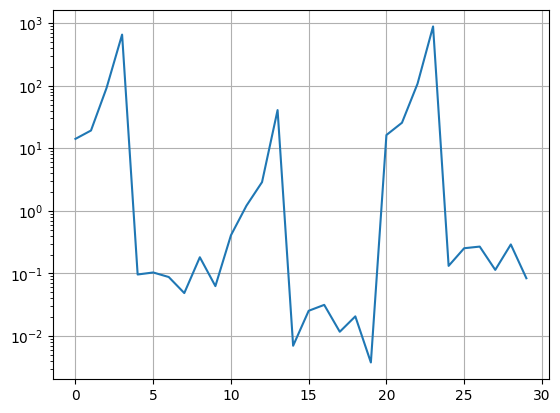

In [63]:
pyplot.grid(visible=True)
pyplot.yscale("log")
pyplot.plot(X_train.mean(axis=0))
pyplot.show()

Можно заметить, что некоторые признаки в среднем варьируются возле 1000, тогда как другие меньше 0.01.

Чтобы это исправить можно отмасштабировать признаки, а именно привести каждый признак к среднему 0 и дисперсии 1.
Помочь в этом может [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) из библиотеки `sklearn`.

Изучите документацию этого алгоритма и реализуйте функцию `scale_features`.

In [75]:
def scale_features(
    train_data: np.ndarray, test_data: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Функция для масштабирования данных
    Переводит каждый столбец данных в новый со средним 0 и дисперсией 1.

    Для подсчета статистики и обучения используется тренировочная часть.
    Затем масштабирование применяется и к тестовым данным.

    Parameters
        ----------
        train_data: матрица размером [train_size; n_features]
            Тренировочная часть
        test_data: матрица размером [test_size; n_features]
            Тестовая часть

        Return
        ------
            train_data_scaled, test_data_scaled
                numpy матрицы с отмасштабированными данными
    """
    # Your code here
    # Создаем экземпляр StandardScaler
    scaler = StandardScaler()

    # Обучаем scaler на тренировочных данных (вычисляем mean и std)
    scaler.fit(train_data)

    # Применяем масштабирование к тренировочным и тестовым данным
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    return train_data_scaled, test_data_scaled

In [77]:
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

mean, std = X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)
assert np.allclose(mean, 0) and np.allclose(std, 1)

Обучите `KNeighborsClassifier` на новых данных, не забудьте подобрать оптимальные гиперпараметры.
Возможно достить точности выше 95%!

In [94]:
model_v3 = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
model_v3.fit(X_train_scaled, y_train)
y_pred_v3 = model_v3.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v3)

Accuracy: 96.49%
F1-score: 95.24%


Задачу классификации можно решать множеством разных способов, многие из которых реализованы в библиотеки `sklearn`.

Вы можете ознакомиться со всем списком алгоритмов в библиотеке [здесь](https://scikit-learn.org/stable/supervised_learning.html). Не все они подходят для задачи классификации, ориентируйтесь на слово `Classifier` в названии, а также не стесняйтесь переходить по ссылкам и читать документацию и описание.

Попробуйте применить новые алгоритмы к нашей задаче. Рекомендуем обратить внимание на:
1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
2. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)
3. [`SVC`](https://scikit-learn.org/stable/modules/svm.html#classification)

Для методов на основе линейных преобразований полезно использовать отмасштабированные данные.

Вполне реально получить идеальное качество в 100%!

In [108]:
from sklearn.svm import SVC
model_v4 = SVC()
model_v4.fit(X_train_scaled, y_train)
y_pred_v4 = model_v4.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v4)

Accuracy: 100.00%
F1-score: 100.00%


In [110]:
from sklearn.linear_model import LogisticRegression
model_v5 = LogisticRegression()
model_v5.fit(X_train_scaled, y_train)
y_pred_v5 = model_v5.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v5)

Accuracy: 98.25%
F1-score: 97.56%


In [112]:
from sklearn.ensemble import RandomForestClassifier
model_v6 = RandomForestClassifier()
model_v6.fit(X_train_scaled, y_train)
y_pred_v6 = model_v6.predict(X_test_scaled)

print_classification_report(y_test, y_pred_v6)

Accuracy: 98.25%
F1-score: 97.56%


# Регрессия

Для знакомства с задачей регрессии, нам поможет популярный датасет [Boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), он прикреплен к заданию в файле `boston.csv`.
Это набор данных с информаций о медианной стоимости домов, а также различных характеристик района.
Ознакомиться с датасетом можно по ссылке выше, а ниже представленно описание каждого столбца в данных:
```
1. crim      per capita crime rate by town
2. zn        proportion of residential land zoned for lots over 25,000 sq.ft.
3. indus     proportion of non-retail business acres per town
4. chas      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. nox       nitric oxides concentration (parts per 10 million)
6. rm        average number of rooms per dwelling
7. age       proportion of owner-occupied units built prior to 1940
8. dis       weighted distances to five Boston employment centres
9. rad       index of accessibility to radial highways
10. tax      full-value property-tax rate per \$10,000
11. ptratio  pupil-teacher ratio by town
12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. lstat    % lower status of the population
14. medv     median value of owner-occupied homes in \$'s
```

Наша задача — научится предсказывать стоимость дома по критериям района. То есть вместо ограниченного числа значений, модель теперь должна предсказывать любые целые числа.

Начнем с функции `read_boston_dataset`, которая считывает датасет с диска. В данных первые 14 строчек не относятся к данным, а описывают колонки, для их пропуска полезно использовать `skiprows` в функции `read_csv`.

In [120]:
def read_boston_dataset(path_to_csv: str, shuffle: bool = True) -> np.ndarray:
    """Функция для чтения данных с диска, а также их случайного перемешивания

    Parameters
    ----------
    path_to_csv: Путь к файлу boston.csv
    shuffle: Если True, то перемешивает данные

    Return
    ------
    dataframe: Данные в формате DataFrame
    """
    # Your code here
    # Чтение данных из CSV-файла
    dataframe = pd.read_csv(path_to_csv, skiprows=14)
    
    # Если нужно перемешать данные
    if shuffle:
        dataframe = dataframe.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    return dataframe

In [122]:
boston_dataset = read_boston_dataset("boston.csv")
boston_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01501,90.0,1.21,1,0.401,7.923,24.8,5.8850,1,198.0,13.6,395.52,3.16,50000.0
1,0.12757,30.0,4.93,0,0.428,6.393,7.8,7.0355,6,300.0,16.6,374.71,5.19,23700.0
2,0.53412,20.0,3.97,0,0.647,7.520,89.4,2.1398,5,264.0,13.0,388.37,7.26,43100.0
3,0.02763,75.0,2.95,0,0.428,6.595,21.8,5.4011,3,252.0,18.3,395.63,4.32,30800.0
4,0.04113,25.0,4.86,0,0.426,6.727,33.5,5.4007,4,281.0,19.0,396.90,5.29,28000.0


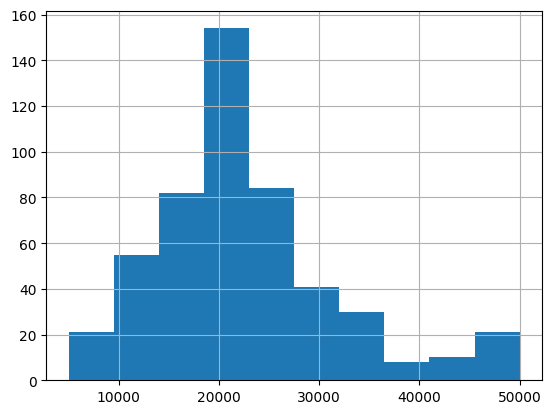

In [124]:
# Посмотрим на данные чуть ближе
# Оценим распределение цен в датасете

pyplot.hist(boston_dataset["medv"])
pyplot.grid(visible=True)
pyplot.show()

**Вопрос:** сделайте 2-3 вывода относительно цен.

1. Основная концентрация владельцев домов приходится на медианную стоимость 10000-30000 тысяч долларов
2. Больше всего владельцев домов стоимостью 20000 тысяч долларов
3. Распредение данных имеют признак нормального распределения

По аналогии с задачей классификацией, необходимо выделить тренировочную и тестовую выборку.
Реализуйте для этого функцию `prepare_boston_dataset`

In [132]:
def prepare_boston_dataset(
    dataset: pd.DataFrame, label_col_name: str = "medv", test_size: float = 0.1
) -> tuple[np.ndarray, ...]:
    """Функция для выделения таргета и признаков,
    а также разделения на тренировочную и тестовую части.

    Parameters
    ----------
    dataset: DataFrame с датасетом
    label_col_name: Название колонки с таргетом
    test_size: доля тестовой выборки относительно всего датасета

    Return
    ------
        4 numpy массива: X_train, X_test, y_train, y_test
        X_train, X_test -- матрицы признаков размером [n_elements; 13]
        y_train, y_test -- массивы с ценами размером [n elements]
    """
    # Your code here
    # Выделяем признаки (все колонки, кроме label_col_name)
    X = dataset.drop(columns=[label_col_name]).values

    # Выделяем таргет
    y = dataset[label_col_name].values

    # Разделяем данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_SEED
    )

    return X_train, X_test, y_train, y_test

In [134]:
X_train, X_test, y_train, y_test = prepare_boston_dataset(boston_dataset)

# Код ниже проверяет правильность подготовки данных
# Если он упал, то надо исправить функцию выше

assert X_train.shape == (455, 13) and y_train.shape == (455,)
assert X_test.shape == (51, 13) and y_test.shape == (51,)

Аналогично задаче классификации, начнем с наивного решения. Для задаче регрессии можно использовать, например, среднее значение по датасету. Однако вы можете предложить и свою оценку на основе анализа графика и вывода выше.

Реализуйте методы `fit` и `predict` у класса ниже.

In [136]:
class MeanRegression:
    def __init__(self):
        self.mean_value = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Функция обучения наивной модели.
        Она получает на вход X и y,
        чтобы иметь схожий интерфейс с другими моделями.

        Функция определяет среднюю величину таргета
        и сохраняет его в mean_value

        Parameters
        ----------
        X: признаки, не используются
        y: таргет, целые числа, одномерный массив
        """
        # Your code here
        self.mean_value = np.mean(y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Функция для предсказания классов

        Parameters
        ----------
        X: элементы, для которых надо предсказать значение
            матрица размером [n_elements; n_features]

        Return
        ------
            предсказанные значения для каждого элемента
            numpy массив размером [n_elements]
        """
        if self.mean_value is None:
            raise RuntimeError("Call fit before predict")
        # Your code here
        # Возвращаем массив, где для каждого элемента предсказано среднее значение
        return np.full(shape=X.shape[0], fill_value=self.mean_value)

Обучим "наивную" модель и оценим ее качество.

В задаче регресии также существует большое множество метрик. Ознакомиться с ними можно, например, [тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8).

В нашем случае мы также будем использовать две метрики:
1. MSE (Mean Squared Error) — среднее квадратичное отклонение, интуитивно понятная метрика, но не всегда хорошо интерпретируется.

2. R2-score — "нормированная" MSE, не имеет границы снизу, 0 в случае предсказания среднего значения и 1 для идеальной работы.

In [138]:
def print_regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}", f"R2-score: {r2:.2f}", sep="\n")

In [140]:
model_mean = MeanRegression()
model_mean.fit(X_train, y_train)
y_pred_mean = model_most_common.predict(X_test)

print_regression_report(y_test, y_pred_mean)

MSE: 568525294.12
R2-score: -7.46


Получили низкое качество, поэтому перейдем к более серьезным моделям.

Одна из них — это линейная регрессия. Интутивно простая модель, но крайне выразительно и часто применяющаяся в различных вариациях и модификациях. Линейная регрессия предпологает линейную зависимость между признаками и таргетами и описывается следующей формулой:

$$
y = w_1 * x_1 + w_2 * x_2 + \dots + w_n + x_n + b = \sum_{i=1}^n w_i x_i + b
$$

Здесь $y$ — это таргет, $x_1, \dots x_n$ — признаки, а $w_1, \dots, w_n$ и $b$ — <u>параметры</u> модели.

В ходе тренировки модели эти параметры автоматически подбираются под обучающие данные.

Конечно, предполагать линейную зависимость между признаками и таргетом во многих случаях бывает невозможно. Для этого можно воспользоваться специальными ядрами, нелинейными преобразованиями, для обработки данных, созданием [полиномиальных признаков](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) или воспользоваться одной из [модификацией](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) уже реализованной в `sklearn`.

Обучим [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) из `sklearn`

In [143]:
model_v1 = LinearRegression(n_jobs=-1)
model_v1.fit(X_train, y_train)
y_pred_v1 = model_v1.predict(X_test)

print_regression_report(y_test, y_pred_v1)

MSE: 24772681.22
R2-score: 0.63


Качество модели значительно лучше.

Давайте проанализируем полученную модель, а именно посмотрим какие веса $w$ получились для каждого признака:

In [145]:
feature_names = boston_dataset.columns[:-1]
coefs = model_v1.coef_

for name, cf in sorted(zip(feature_names, coefs), key=lambda x: x[1], reverse=True):
    print(f"{name}\t{cf}")

rm	3703.226466679449
chas	2718.0030165688518
rad	286.6149353473318
zn	52.1634174952045
b	8.755843885440484
age	-3.885524289723767
indus	-10.813573223239127
tax	-12.393095505981869
crim	-110.50222274638247
lstat	-515.8381846056585
ptratio	-887.7297171578947
dis	-1513.6749330211273
nox	-16434.529666360464


**Вопрос:** как можно интерпретировать полученный список?

**Ответ:** Полученный список показывает веса (коэффициенты) модели линейной регрессии для каждого признака. Эти веса указывают на то, как каждый признак влияет на целевую переменную (medv — медианная стоимость домов). 

1. Признаки с положительными коэффициентами:
Эти признаки положительно влияют на стоимость домов. Чем больше их значение, тем выше предсказанная стоимость.

2. Признаки с отрицательными коэффициентами:
Эти признаки отрицательно влияют на стоимость домов. Чем больше их значение, тем ниже предсказанная стоимость.

Внутри `sklearn` есть множество алгоритмов регрессии, попробуйте применить их для этой задачи.

Например, можно взглянуть на [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), довольно мощный алгоритм, но требующий детальной настройки.

В этой задаче можно получить R2-score больше 0.9, удачи!

In [213]:
from sklearn.ensemble import GradientBoostingRegressor

model_v2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=RANDOM_SEED)
model_v2.fit(X_train, y_train)
y_pred_v2 = model_v2.predict(X_test)

print_regression_report(y_test, y_pred_v2)

MSE: 7233339.54
R2-score: 0.89


# Кластеризация

Последний блок нашей практики посвящен задаче кластеризации, задаче где отсутствуют таргеты и необходимо уметь группировать данные в осмысленные блоки. Примерами задачи кластеризации может служить разбиение новостей по разным темам или выявление пользователей в соц. сетях с общими интересами.

Мы применим кластеризацию к картинкам, что может быть полезно, если необходимо ее сжать.

Выберите любую картинку, может быть любимый шаблон мема или чья-то фотография. Пример подходящей картинки прикреплен к практике, в файле `image.jpg`. 

In [216]:
def read_image(image_path: str) -> np.ndarray:
    with Image.open(image_path) as img:
        data = np.array(img)
    return data


def show_image(image: np.ndarray) -> np.ndarray:
    pyplot.axis("off")
    pyplot.tight_layout()
    pyplot.imshow(image)
    pyplot.show()

In [218]:
# Разместите картинку рядом с тетрадкой
# И укажите ее название в переменной ниже

IMAGE_NAME = "image.jpg"

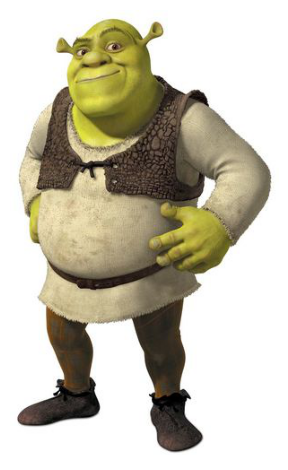

In [220]:
image = read_image(IMAGE_NAME)
height, width = image.shape[:2]

show_image(image)

Картинка в памяти хранится как трехмерный массив `[h; w; 3]`, однако алгоритмы кластеризации требуют от нас двумерный массив `[n_samples; n_features]`. В случае картинок, `n_features` — 3, RGB код цвета каждого пикселя, а `n_samples` общее число пикселей.

Реализуйте функцию `preprocess_image`, которая получает картинку и возвращает нужный двумерный массив.

In [222]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """Функция для препроцессинга картинки

    Parameters
    ----------
    image: исходная картинка
        массив размером [h; w; 3]

    Return
    ------
        матрица размером [n_pixels; 3]
    """
    # Your code here
    # Получаем размеры изображения
    h, w, c = image.shape

    # Преобразуем изображение в двумерный массив [n_pixels; 3]
    pixels = image.reshape(-1, c) # -1 означает, что NumPy автоматически вычислит размер по этой оси (в данном случае, n_pixels = h * w)

    return pixels

In [224]:
X_train = preprocess_image(image)

assert X_train.shape == (height * width, 3)

В качестве первого алгоритма возьмем [`KMeans`](https://scikit-learn.org/stable/modules/clustering.html#k-means). Его идея близка к алгоритму классификации "K ближайших соседей", считаются попарные расстояния между точками и наиболее близкие объединяются в кластеры

In [227]:
k_means = KMeans(n_clusters=5, n_init=1, random_state=RANDOM_SEED)
k_means.fit(X_train)

KMeans(n_clusters=5, n_init=1, random_state=12648430)

Заменим каждый цвет на картинке на средний цвет кластера, куда попал соответствующий кластер.

Для этого реализуйте функцию `replace_to_centroid`, которая принимает полученные индексы кластеров и цвета кластеров и возвращает цвета для каждой точки.

In [229]:
def replace_to_centroid(
    predicted_cluster: np.ndarray, centroids: np.ndarray
) -> np.ndarray:
    """Функция для получения центроиды кластера по ее индексу

    Parameters
    ----------
    predicted_cluster: предсказанные кластеры
        массив размером [n_samples]
        каждое значение от 0 до n_clusters
    centroids: центры кластеров
        массив размером [n_clusters; 3]

    Return
    ------
        матрица размером [n_samples; 3]
    """
    # Your code here
    return centroids[predicted_cluster]

In [231]:
predicted_clusters = k_means.predict(X_train)
X_predicted = replace_to_centroid(predicted_clusters, k_means.cluster_centers_)

assert X_predicted.shape == X_train.shape

Приведем матрицу обратно к формату картинки и посмотрим, что получилось!

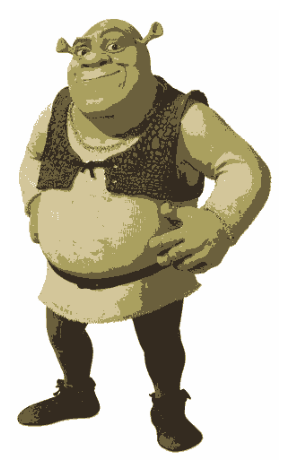

In [234]:
new_image = X_predicted.reshape(height, width, 3).astype(np.int32)
show_image(new_image)

Изучите другие алгоритмы кластеризации, доступные в `sklearn`: [алгоритмы](https://scikit-learn.org/stable/modules/clustering.html).

Для применения к нашей задаче, необходимо выбрать такой, где задается число кластеров, обычно параметр называется `n_clusters`. Помните, что задача кластеризации трудная с вычислительной точки зрения, домашний ПК не всегда может с ней справиться.

Поэкспериментируйте с другими алгоритмами и сравните, как они ведут себя относительно `KMeans` для задачи сжатия изображений.

In [236]:
from sklearn.cluster import MiniBatchKMeans

# Преобразуем изображение в массив пикселей
pixels = preprocess_image(image)

# Применяем MiniBatchKMeans
mb_kmeans = MiniBatchKMeans(
    n_clusters=5,  # Количество кластеров
    random_state=RANDOM_SEED,
    batch_size=1000  # Размер мини-батча
)

In [238]:
mb_kmeans.fit(pixels)

# Получаем индексы кластеров и центроиды
predicted_clusters = mb_kmeans.labels_
centroids = mb_kmeans.cluster_centers_.astype(int)

D:\anaconda3\envs\gpu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [240]:
# Заменяем цвета пикселей на цвета центроидов
new_pixels = replace_to_centroid(predicted_clusters, centroids)

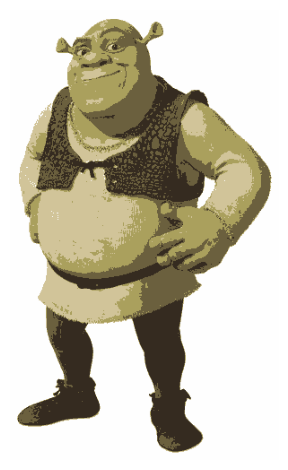

In [242]:
# Восстанавливаем изображение
new_image = new_pixels.reshape(image.shape).astype(np.int32)

# Показываем новое изображение
show_image(new_image)